In [1]:
# Installing required libraries
!pip install dice-ml
!pip install scikit-learn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 41.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 1.5.3 which is incompatible.
xarray 2024.6.0 requires pandas>=2.0, but you have pandas 1.5.3 which is incompatible.


In [2]:
# Importing required libraries
import dice_ml
from dice_ml import Dice
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Importing dataset
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('credit_risk_dataset.csv')
df.head()

Saving credit_risk_dataset.csv to credit_risk_dataset.csv


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split # Import train_test_split

# Assuming 'df' is your DataFrame
X = df.drop('loan_status', axis=1)  # Features
y = df['loan_status']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split the data

# Creating an OrdinalEncoder object
encoder = OrdinalEncoder()

# Selecting categorical columns
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Creating a SimpleImputer to fill missing values with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')

# Fitting the imputer on the categorical columns and transform them
X_train[categorical_cols] = imputer.fit_transform(X_train[categorical_cols])

# Doing the same for X_test using the trained imputer
X_test[categorical_cols] = imputer.transform(X_test[categorical_cols])

# Fitting the encoder on the imputed categorical columns and transform them
X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])

# Doing the same for X_test using the trained encoder
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols])

# Imputing missing values in all columns of X_train and X_test
imputer = SimpleImputer(strategy='most_frequent') # Creating a new imputer for all columns
X_train = imputer.fit_transform(X_train) # Fitting and transform on X_train
X_test = imputer.transform(X_test) # Transforming X_test

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [5]:
# Creating a DiCE data object and initialising the Explainer
# Converting X_train back to a DataFrame with original column names
X_train_df = pd.DataFrame(X_train, columns=X.columns)

dice_data = dice_ml.Data(dataframe=pd.concat([X_train_df, y_train], axis=1),
                         continuous_features=X.columns.tolist(),
                         outcome_name=y.name)

# Using the trained random forest model as a black box model in DiCE
dice_model = dice_ml.Model(model=model, backend="sklearn")
dice = Dice(dice_data, dice_model)

In [6]:
# Selecting a test instance
query_instance = pd.DataFrame(X_test[0:1], columns=X.columns) # Converting the first row of X_test back to a DataFrame

# Generating Counterfactuals for test instance
counterfactuals = dice.generate_counterfactuals(query_instance, total_CFs=3, desired_class="opposite")
counterfactuals.visualize_as_dataframe()

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but Rand

Query instance (original outcome : 0)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,24.0,28000.0,2.0,6.0,2.0,1.0,10000.0,10.37,0.36,0.0,2.0,0



Diverse Counterfactual set (new outcome: 1)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,24.0,28000.0,3.0,6.0,2.0,1.0,10000.0,11.39,0.36,0.0,2.0,1
1,24.0,28000.0,2.9,6.0,1.6,1.0,10000.0,10.37,0.36,0.0,2.0,1
2,24.0,28000.0,2.0,6.0,2.0,3.3,10000.0,19.44,0.36,0.0,2.0,1


In [7]:
# Visualisation of the original instance and the counterfactuals
print("Originale Instanz:")
print(query_instance)
print("\nGenerierte Counterfactuals:")
# Only print the first counterfactual and drop the target column
print(counterfactuals.cf_examples_list[0].final_cfs_df.iloc[[0], :-1])

#  Difference between the original instance and the counterfactuals
# Calculate the difference between the first counterfactual and the query instance
diff = query_instance.values - counterfactuals.cf_examples_list[0].final_cfs_df.iloc[[0], :-1].values
print("\nÄnderungen in den Merkmalen (Differenz):")
print(diff)

Originale Instanz:
   person_age  person_income  person_home_ownership  person_emp_length  \
0        24.0        28000.0                    2.0                6.0   

   loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0          2.0         1.0    10000.0          10.37                 0.36   

   cb_person_default_on_file  cb_person_cred_hist_length  
0                        0.0                         2.0  

Generierte Counterfactuals:
   person_age  person_income  person_home_ownership  person_emp_length  \
0        24.0        28000.0                    3.0                6.0   

   loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0          2.0         1.0    10000.0          11.39                 0.36   

   cb_person_default_on_file  cb_person_cred_hist_length  
0                        0.0                         2.0  

Änderungen in den Merkmalen (Differenz):
[[ 0.    0.   -1.    0.    0.    0.    0.   -1.02  0.    0.    0. 

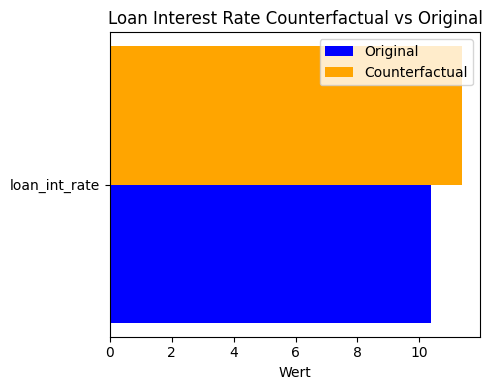

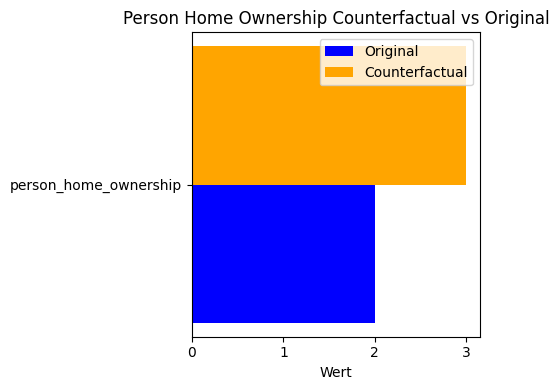

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def visualize_counterfactual(cf, original, title):
    # Ensuring that the data is available as numpy arrays
    cf_values = np.array(cf)
    original_values = np.array(original)

    # Checking whether the lengths match (important for plotting)
    if len(cf_values) != len(original_values):
        print("Die Länge der Counterfactuals und der Originaldaten stimmen nicht überein.")
        return

    # Index of features (y-axis)
    index = np.arange(len(original))  # Index for the number of features
    bar_width = 0.35  # Width of the bars

    plt.figure(figsize=(5, 4))  # Larger figure for better visualisation

    # Bars for original instance
    plt.barh(index, original_values, bar_width, color='blue', label='Original')

    # Bars for Counterfactual
    plt.barh(index + bar_width, cf_values, bar_width, color='orange', label='Counterfactual')

    # Set the y-ticks and labels
    # Use the index of the Series for the labels
    plt.yticks(index + bar_width / 2, original.index)
    plt.xlabel('Wert')
    plt.title(title)
    plt.legend(loc='upper right')

    # Customise layout and display plot
    plt.tight_layout()
    plt.show()

# Example data for the original and the counterfactual
# The example data only has values for person_home_ownership and loan_int_rate
original_instance = [2.0, 10.37] # Person home ownership and loan interest rate
counterfactual_instance = [3.0,  11.39] # Person home ownership and interest rate

# Feature-names
feature_names = ['person_home_ownership', 'loan_int_rate']

# Converts the lists into Pandas Series
original_instance = pd.Series(original_instance, index=feature_names)
counterfactual_instance = pd.Series(counterfactual_instance, index=feature_names)

# Visualise the example for loan grade
visualize_counterfactual(pd.Series([counterfactual_instance['loan_int_rate']], index=['loan_int_rate']),
                         pd.Series([original_instance['loan_int_rate']], index=['loan_int_rate']),
                         "Loan Interest Rate Counterfactual vs Original")

# Visualise the example for person home ownership
visualize_counterfactual(pd.Series([counterfactual_instance['person_home_ownership']], index=['person_home_ownership']),
                         pd.Series([original_instance['person_home_ownership']], index=['person_home_ownership']),
                         "Person Home Ownership Counterfactual vs Original")